In [17]:
# -*- coding: utf-8 -*-
import os
import warnings
from typing import Dict, List, Tuple, Optional

# warnings.filterwarnings('ignore')
os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf

import bayesflow as bf
from bayesflow.adapters.transforms import Transform
from bayesflow.adapters.transforms.map_transform import MapTransform

from hmmlearn import hmm
from hmmlearn.hmm import CategoricalHMM

from sklearn.preprocessing import LabelEncoder

current_backend = tf.keras.backend.backend()
print(f"tf.keras is using the '{current_backend}' backend.")

tf.keras is using the 'tensorflow' backend.


In [18]:
# HMM PARAMETERS FROM TASK DESCRIPTION

# 20 amino acids in standard order
AMINO_ACIDS = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 
               'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

# Emission probabilities from task tables
# Alpha-helix state (state 0)
EMISSION_ALPHA = [0.12, 0.06, 0.03, 0.05, 0.01, 0.09, 0.05, 0.04, 0.02, 0.07,
                  0.12, 0.06, 0.03, 0.04, 0.02, 0.05, 0.04, 0.01, 0.03, 0.06]

# Other state (state 1) 
EMISSION_OTHER = [0.06, 0.05, 0.05, 0.06, 0.02, 0.05, 0.03, 0.09, 0.03, 0.05,
                  0.08, 0.06, 0.02, 0.04, 0.06, 0.07, 0.06, 0.01, 0.04, 0.07]

# Transition probabilities from task description
# [alpha->alpha, alpha->other]
TRANS_FROM_ALPHA = [0.90, 0.10]
# [other->alpha, other->other]  
TRANS_FROM_OTHER = [0.05, 0.95]

# Initial state probabilities (always starts in "other" state)
INITIAL_PROBS = [0.0, 1.0]  # [alpha-helix, other]

# Validation
print("PARAMETER VALIDATION:")
print(f"Amino acids: {len(AMINO_ACIDS)} types")
print(f"Alpha emission sum: {sum(EMISSION_ALPHA):.3f}")
print(f"Other emission sum: {sum(EMISSION_OTHER):.3f}")
print(f"Alpha transitions sum: {sum(TRANS_FROM_ALPHA):.3f}")
print(f"Other transitions sum: {sum(TRANS_FROM_OTHER):.3f}")
print(f"Initial probs sum: {sum(INITIAL_PROBS):.3f}")
print("\n✓ All probabilities are valid!")

PARAMETER VALIDATION:
Amino acids: 20 types
Alpha emission sum: 1.000
Other emission sum: 1.000
Alpha transitions sum: 1.000
Other transitions sum: 1.000
Initial probs sum: 1.000

✓ All probabilities are valid!


In [19]:
# FIXED HMM MODEL CREATION

def create_fixed_hmm():
    """
    Create HMM with fixed parameters from task description.
    
    States: 0=alpha-helix, 1=other
    Features: 20 amino acids (0-19 indices)
    
    Returns:
        CategoricalHMM with fixed empirical parameters
    """
    # Create model with fixed parameters (no learning)
    model = hmm.CategoricalHMM(
        n_components=2,        # 2 states: alpha-helix, other
        n_features=20,         # 20 amino acids
        params="",             # Don't update any parameters
        init_params="",        # Don't initialize any parameters
        algorithm="viterbi",   # Use Viterbi algorithm for decoding
        verbose=True
    )
    
    # Set fixed parameters from task description
    model.startprob_ = np.array(INITIAL_PROBS)
    model.transmat_ = np.array([TRANS_FROM_ALPHA, TRANS_FROM_OTHER])
    model.emissionprob_ = np.array([EMISSION_ALPHA, EMISSION_OTHER])
    
    return model

# Test HMM creation
print("TESTING HMM CREATION:\n")
hmm_model = create_fixed_hmm()

print(f"States: {hmm_model.n_components}")
print(f"Features: {hmm_model.n_features}")
print(f"Start probabilities: {hmm_model.startprob_}")
print(f"Transition matrix shape: {hmm_model.transmat_.shape}")
print(f"Emission matrix shape: {hmm_model.emissionprob_.shape}")

print("\nTransition probabilities:")
print("From alpha-helix:", hmm_model.transmat_[0])
print("From other:     ", hmm_model.transmat_[1])

print("\nEmission probabilities (first 5 amino acids):")
print("Alpha-helix:", hmm_model.emissionprob_[0][:5])
print("Other:      ", hmm_model.emissionprob_[1][:5])
print("\n✓ HMM model created successfully!")

TESTING HMM CREATION:

States: 2
Features: 20
Start probabilities: [0. 1.]
Transition matrix shape: (2, 2)
Emission matrix shape: (2, 20)

Transition probabilities:
From alpha-helix: [0.9 0.1]
From other:      [0.05 0.95]

Emission probabilities (first 5 amino acids):
Alpha-helix: [0.12 0.06 0.03 0.05 0.01]
Other:       [0.06 0.05 0.05 0.06 0.02]

✓ HMM model created successfully!


In [42]:
# BAYESFLOW SIMULATOR IMPLEMENTATION

def protein_hmm_simulator(batch_shape, sequence_length=50, random_state=None):
    """
    BayesFlow compatible simulator for protein secondary structure prediction.
    
    This simulator:
    1. Creates amino acid sequences using the fixed HMM parameters from task description
    2. Computes state probabilities using predict_proba (Forward-Backward algorithm)
    3. One-hot encodes amino acid sequences for SetTransformer compatibility
    4. Flattens state probabilities for FlowMatching compatibility
    5. Returns data in BayesFlow compatible format
    
    Parameters:
    -----------
    batch_shape : tuple or int
        Number of sequences to generate
    sequence_length : int, default=50
        Length of each amino acid sequence
    random_state : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    dict : Dictionary with 'sequences' and 'state_probs' keys
        - sequences: one-hot encoded amino acid sequences (batch_size, sequence_length, 20)
        - state_probs: flattened state probabilities (batch_size, sequence_length * 2) for FlowMatching
    """
    # Handle batch_shape input
    if isinstance(batch_shape, int):
        batch_size = batch_shape
    else:
        batch_size = batch_shape[0] if len(batch_shape) > 0 else 1
    
    # Create fixed HMM model
    hmm_model = create_fixed_hmm()
    
    # Set random state for reproducibility
    if random_state is not None:
        np.random.seed(random_state)
        hmm_model.random_state = random_state
    
    # Generate sequences and ground truth states
    sequences = []
    state_probs = []
    
    for i in range(batch_size):
        # Generate amino acid sequence and true state sequence from HMM
        amino_sequence, true_states = hmm_model.sample(n_samples=sequence_length)
        
        # Convert amino acid sequence to proper format
        # hmmlearn returns shape (n_samples, 1), we need (n_samples,)
        amino_sequence = amino_sequence.reshape(-1)
        
        # One-hot encode amino acid sequence
        # Create one-hot encoding: (sequence_length, 20)
        one_hot_sequence = np.zeros((sequence_length, 20), dtype=np.float32)
        for j, aa_idx in enumerate(amino_sequence):
            one_hot_sequence[j, aa_idx] = 1.0
        
        # Compute state probabilities using Forward-Backward algorithm
        # Note: CategoricalHMM expects input of shape (n_samples, 1)
        X_input = amino_sequence.reshape(-1, 1)
        posteriors = hmm_model.predict_proba(X_input)
        
        # Flatten state probabilities for FlowMatching compatibility
        # From (sequence_length, 2) to (sequence_length * 2,)
        flattened_probs = posteriors.reshape(-1).astype(np.float32)
        
        sequences.append(one_hot_sequence)
        state_probs.append(flattened_probs)
    
    # Convert to numpy arrays
    sequences = np.array(sequences, dtype=np.float32)  # (batch_size, sequence_length, 20)
    state_probs = np.array(state_probs, dtype=np.float32)  # (batch_size, sequence_length * 2)
    
    return {
        'sequences': sequences,
        'state_probs': state_probs,
    }

# Create BayesFlow LambdaSimulator
simulator = bf.simulators.LambdaSimulator(
    sample_fn=protein_hmm_simulator,
    is_batched=True  # Our function handles batching internally
)

print("✓ BayesFlow simulator created successfully!")

✓ BayesFlow simulator created successfully!


In [43]:
# TEST THE UPDATED SIMULATOR
print("TESTING UPDATED PROTEIN HMM SIMULATOR:\n")

# Test with small batch
test_batch_size = 3
test_sequence_length = 20

# Generate test data
test_data = simulator.sample(batch_shape=(test_batch_size,), 
                           sequence_length=test_sequence_length, 
                           random_state=42)

print(f"Generated data for {test_batch_size} sequences of length {test_sequence_length}")
print(f"Sequences shape (one-hot):\t {test_data['sequences'].shape}")
print(f"State probabilities shape (flattened):\t {test_data['state_probs'].shape}")

# Convert one-hot back to amino acid indices for display
first_sequence_indices = np.argmax(test_data['sequences'][0], axis=1)
print("\nFirst sequence (amino acid indices 0-19):")
print(first_sequence_indices)

print("\nCorresponding amino acids:")
amino_acid_letters = [AMINO_ACIDS[i] for i in first_sequence_indices]
print(''.join(amino_acid_letters))

# Reshape flattened state probabilities back to (sequence_length, 2) for display
first_state_probs_reshaped = test_data['state_probs'][0].reshape(test_sequence_length, 2)
print("\nState probabilities for first sequence (first 10 positions):")
print("Position | Alpha-helix | Other")
print("-" * 30)
for i in range(min(10, test_sequence_length)):
    alpha_prob = first_state_probs_reshaped[i, 0]
    other_prob = first_state_probs_reshaped[i, 1]
    print(f"{i:8d} | {alpha_prob:11.3f} | {other_prob:5.3f}")

# Verify probabilities sum to 1 (after reshaping)
prob_sums = np.sum(first_state_probs_reshaped, axis=1)
print(f"\nProbability sums (should be close to 1.0): {prob_sums[:5]}")

print(f"\nFlattened shape verification:")
print(f"  Original shape would be: (batch=3, seq=20, states=2)")
print(f"  Flattened shape is: (batch=3, features={test_data['state_probs'].shape[1]})")
print(f"  Expected flattened size: 20*2 = 40")
print(f"  ✓ Correct: {test_data['state_probs'].shape[1] == 40}")

print("\n✓ Updated simulator test completed successfully!")

TESTING UPDATED PROTEIN HMM SIMULATOR:

Generated data for 3 sequences of length 20
Sequences shape (one-hot):	 (3, 20, 20)
State probabilities shape (flattened):	 (3, 40)

First sequence (amino acid indices 0-19):
[19 11  2 16 14 19  3  2  9  5  1  6 13  9  0  1 19 15  1  9]

Corresponding amino acids:
VKNTPVDNIERQFIARVSRI

State probabilities for first sequence (first 10 positions):
Position | Alpha-helix | Other
------------------------------
       0 |       0.000 | 1.000
       1 |       0.018 | 0.982
       2 |       0.025 | 0.975
       3 |       0.037 | 0.963
       4 |       0.052 | 0.948
       5 |       0.114 | 0.886
       6 |       0.184 | 0.816
       7 |       0.269 | 0.731
       8 |       0.427 | 0.573
       9 |       0.540 | 0.460

Probability sums (should be close to 1.0): [1. 1. 1. 1. 1.]

Flattened shape verification:
  Original shape would be: (batch=3, seq=20, states=2)
  Flattened shape is: (batch=3, features=40)
  Expected flattened size: 20*2 = 40
  ✓ Correct

VISUALIZING SIMULATOR DATA:



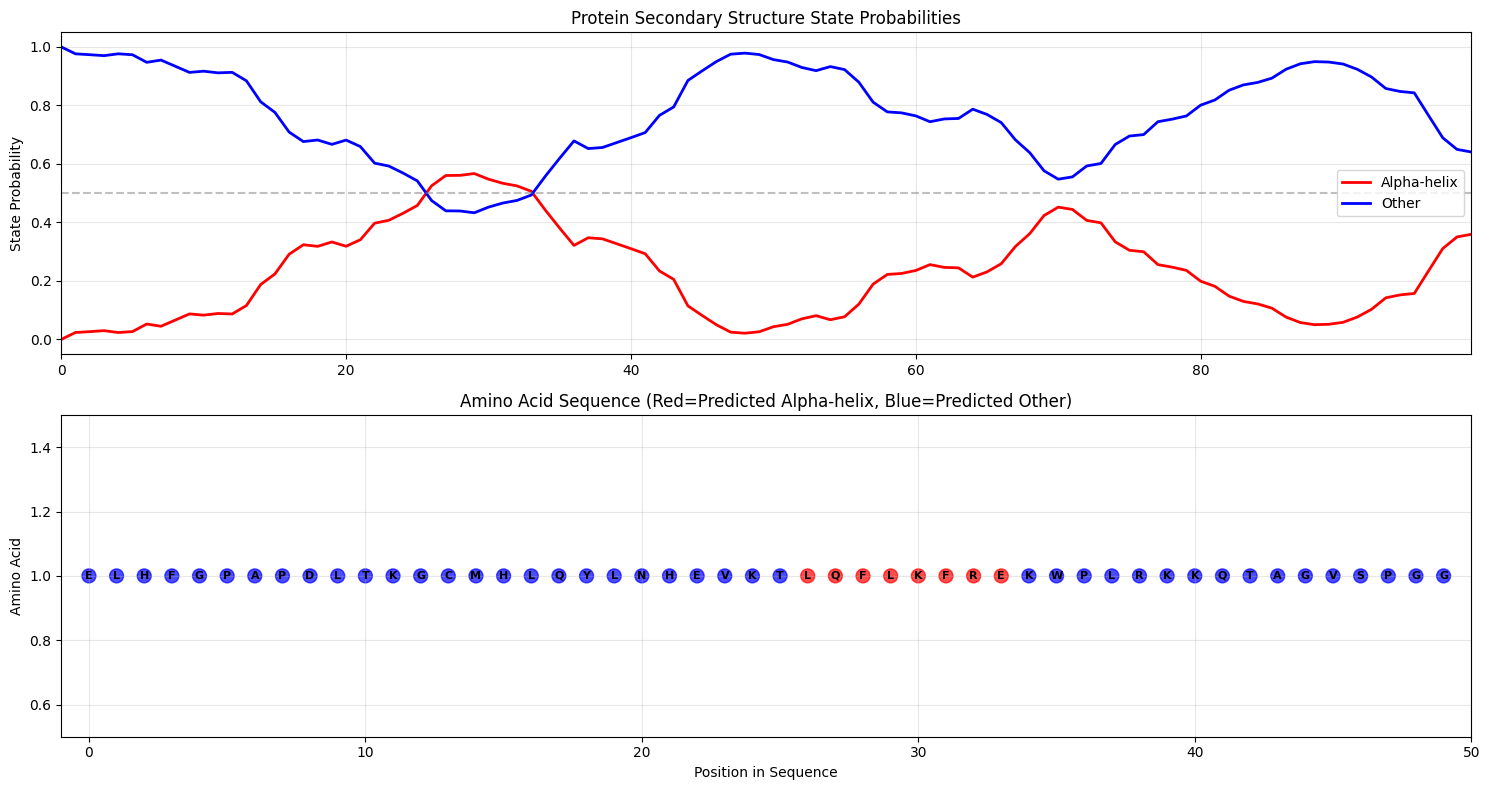

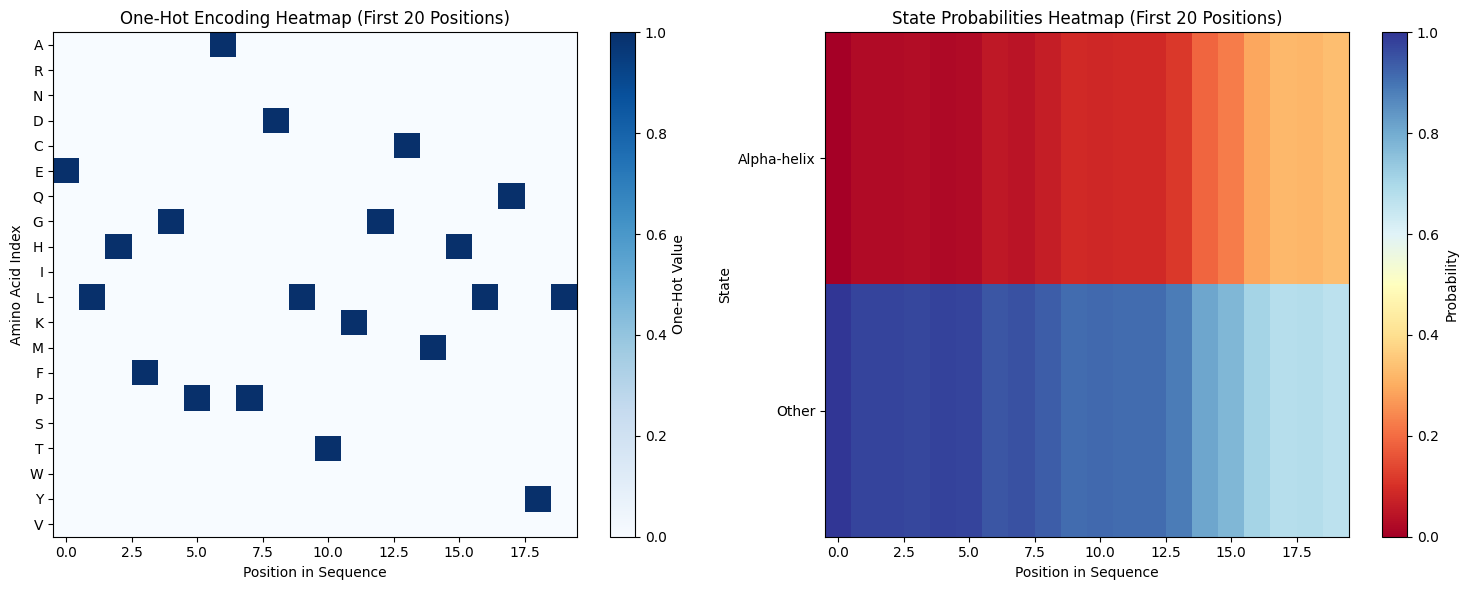

In [45]:
# VISUALIZE SIMULATOR OUTPUT

print("VISUALIZING SIMULATOR DATA:\n")

# Generate a longer sequence for better visualization
vis_data = simulator.sample(batch_shape=(1,), sequence_length=100, random_state=123)

# Extract data for plotting
sequence_one_hot = vis_data['sequences'][0]  # Shape: (100, 20)
state_probs_flat = vis_data['state_probs'][0]  # Shape: (200,) - flattened

# Convert one-hot back to amino acid indices
sequence_indices = np.argmax(sequence_one_hot, axis=1)

# Create amino acid letters for visualization
amino_letters = [AMINO_ACIDS[i] for i in sequence_indices]

# IMPORTANT: Reshape flattened state probabilities back to 2D
sequence_length = len(sequence_indices)
state_probs = state_probs_flat.reshape(sequence_length, 2)  # Back to (100, 2)

# Plot state probabilities over the sequence
plt.figure(figsize=(15, 8))

# Plot 1: State probabilities
plt.subplot(2, 1, 1)
positions = np.arange(len(sequence_indices))
plt.plot(positions, state_probs[:, 0], 'r-', label='Alpha-helix', linewidth=2)
plt.plot(positions, state_probs[:, 1], 'b-', label='Other', linewidth=2)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.ylabel('State Probability')
plt.title('Protein Secondary Structure State Probabilities')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, len(sequence_indices)-1)

# Plot 2: Amino acid sequence (first 50 positions for readability)
plt.subplot(2, 1, 2)
display_length = min(50, len(sequence_indices))
positions_short = np.arange(display_length)
colors = ['red' if state_probs[i, 0] > 0.5 else 'blue' for i in range(display_length)]

plt.scatter(positions_short, [1]*display_length, c=colors, s=100, alpha=0.7)
for i, letter in enumerate(amino_letters[:display_length]):
    plt.text(i, 1, letter, ha='center', va='center', fontsize=8, fontweight='bold')

plt.ylim(0.5, 1.5)
plt.xlim(-1, display_length)
plt.xlabel('Position in Sequence')
plt.ylabel('Amino Acid')
plt.title('Amino Acid Sequence (Red=Predicted Alpha-helix, Blue=Predicted Other)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional visualization: One-hot encoding heatmap
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
# Show one-hot encoding for first 20 positions
one_hot_subset = vis_data['sequences'][0][:20, :].T  # Shape: (20, 20)
plt.imshow(one_hot_subset, cmap='Blues', aspect='auto')
plt.xlabel('Position in Sequence')
plt.ylabel('Amino Acid Index')
plt.title('One-Hot Encoding Heatmap (First 20 Positions)')
plt.colorbar(label='One-Hot Value')

# Add amino acid labels on y-axis
plt.yticks(range(20), AMINO_ACIDS)

plt.subplot(1, 2, 2)
# Show state probabilities as heatmap (reshape the flattened data)
state_probs_subset = state_probs[:20, :].T  # Shape: (2, 20)
plt.imshow(state_probs_subset, cmap='RdYlBu', aspect='auto')
plt.xlabel('Position in Sequence')
plt.ylabel('State')
plt.title('State Probabilities Heatmap (First 20 Positions)')
plt.colorbar(label='Probability')
plt.yticks([0, 1], ['Alpha-helix', 'Other'])

plt.tight_layout()
plt.show()

In [ ]:
# # BAYESFLOW RESHAPE TRANSFORM

# n_states = 2  # Number of states (alpha-helix, other)
# SEQUENCE_LENGTH = 20
    
# class ReshapeTransform(Transform):
#     """Custom transform to reshape posteriors from (batch, seq, states) to (batch, seq*states)"""
    
#     def __init__(self, sequence_length=20, n_states=2):
#         super().__init__()
#         self.sequence_length = sequence_length
#         self.n_states = n_states
    
#     def forward(self, data, **kwargs):
#         """Reshape from (batch, seq, states) to (batch, seq*states)"""
#         batch_size = data.shape[0]
#         return data.reshape(batch_size, -1)  # Flatten last two dimensions

#     def inverse(self, data, **kwargs):
#         """Reshape from (batch, seq*states) back to (batch, seq, states)"""
#         # Handle both (batch, seq*states) and (batch, num_samples, seq*states)
#         if data.ndim == 2:
#             batch_size = data.shape[0]
#             return data.reshape(batch_size, self.sequence_length, self.n_states)
#         elif data.ndim == 3:
#             batch_size, num_samples = data.shape[:2]
#             return data.reshape(batch_size, num_samples, self.sequence_length, self.n_states)
#         else:
#             raise ValueError(f"Unexpected data shape in ReshapeTransform.inverse: {data.shape}")
    
#     def log_det_jac(self, data, log_det_jac, inverse=False, **kwargs):
#         """Jacobian determinant is 1 for reshape operations (no change in log probability)"""
#         return log_det_jac  # No change needed
    
#     def get_config(self):
#         """Return configuration for serialization"""
#         return {
#             'sequence_length': self.sequence_length,
#             'n_states': self.n_states
#         }
    
#     @classmethod
#     def from_config(cls, config, custom_objects=None):
#         """Create instance from configuration"""
#         return cls(**config)

# # Create the adapter with the reshape transform
# adapter = (
#     bf.Adapter()
#     .convert_dtype("float64", "float32")
#     .concatenate("state_probs", into="inference_variables")
#     .concatenate("sequences", into="summary_variables")
# )

# # Create the reshape transform for inference_variables only
# reshape_map = MapTransform(
#     transform_map={"inference_variables": ReshapeTransform(sequence_length=SEQUENCE_LENGTH, n_states=n_states)}
# )

# # Add the transform to the adapter
# adapter = adapter.append(reshape_map)

# print("Complete adapter pipeline:")
# print(adapter)

# # Test the transformation
# print(f"\nTesting transformation:")
# print(f"Original shapes: {[(k, v.shape) for k, v in test_data.items()]}")

# transformed_data = adapter(test_data)
# print(f"Transformed shapes: {[(k, v.shape) for k, v in transformed_data.items()]}")

# # Verify the reshape worked correctly
# original_total = test_data['state_probs'].shape[1] * test_data['state_probs'].shape[2]
# new_features = transformed_data['inference_variables'].shape[1]
# print(f"\nReshape verification:")
# print(f"  Original: (batch=3, seq=20, states=2) -> flatten to: 20*2 = 40")
# print(f"  Result: (batch=3, features={new_features})")
# print(f"  ✓ Correct: {new_features == original_total}")

# print("\n✓ BayesFlow-compatible adapter with reshape transform created successfully!")

Complete adapter pipeline:
Adapter([0: ConvertDType -> 1: Rename('state_probs' -> 'inference_variables') -> 2: Rename('sequences' -> 'summary_variables') -> 3: ReshapeTransform])

Testing transformation:
Original shapes: [('sequences', (3, 20, 20)), ('state_probs', (3, 20, 2))]
Transformed shapes: [('inference_variables', (3, 40)), ('summary_variables', (3, 20, 20))]

Reshape verification:
  Original: (batch=3, seq=20, states=2) -> flatten to: 20*2 = 40
  Result: (batch=3, features=40)
  ✓ Correct: True

✓ BayesFlow-compatible adapter with reshape transform created successfully!


In [46]:
# UPDATED ADAPTER FOR FLATTENED STATE PROBABILITIES

adapter = (
    bf.Adapter()
    .convert_dtype("float64", "float32")
    .concatenate("state_probs", into="inference_variables")
    .concatenate("sequences", into="summary_variables")
)

print("Updated adapter:")
print(adapter)

print(f"\nTesting transformation with new data:")
print(f"Original shapes: {[(k, v.shape) for k, v in test_data.items()]}")

transformed_data = adapter(test_data)
print(f"Transformed shapes: {[(k, v.shape) for k, v in transformed_data.items()]}")

print(f"\nShape verification:")
print(f"  Inference variables: {transformed_data['inference_variables'].shape}")
print(f"  Summary variables: {transformed_data['summary_variables'].shape}")
print(f"  ✓ Inference variables are now rank 2 (compatible with FlowMatching)")
print(f"  ✓ Summary variables maintain rank 3 (compatible with SetTransformer)")

print("\n✓ Updated adapter created successfully!")

Updated adapter:
Adapter([0: ConvertDType -> 1: Rename('state_probs' -> 'inference_variables') -> 2: Rename('sequences' -> 'summary_variables')])

Testing transformation with new data:
Original shapes: [('sequences', (3, 20, 20)), ('state_probs', (3, 40))]
Transformed shapes: [('inference_variables', (3, 40)), ('summary_variables', (3, 20, 20))]

Shape verification:
  Inference variables: (3, 40)
  Summary variables: (3, 20, 20)
  ✓ Inference variables are now rank 2 (compatible with FlowMatching)
  ✓ Summary variables maintain rank 3 (compatible with SetTransformer)

✓ Updated adapter created successfully!


In [47]:
summary_network = bf.networks.SetTransformer()

print(summary_network)

print("\n✓ Summary network created successfully!")

<SetTransformer name=set_transformer_4, built=False>

✓ Summary network created successfully!


In [48]:
inference_network = bf.networks.FlowMatching()

print(inference_network)

print("\n✓ Inference network created successfully!")

<FlowMatching name=flow_matching_3, built=False>

✓ Inference network created successfully!


In [49]:
workflow = bf.workflows.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=summary_network,
    inference_network=inference_network,
    inference_variables="inference_variables",
    summary_variables="summary_variables"
)

print(workflow)

print("\n✓ BayesFlow workflow created successfully!")


✓ BayesFlow workflow created successfully!


In [50]:
history = workflow.fit_online(
    epochs=1,
    num_batches_per_epoch=10,
    batch_size=32,
)

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.
INFO:bayesflow:Building on a test batch.


10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 433ms/step - loss: 17.2854
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 433ms/step - loss: 17.2854


In [51]:
sim_data = simulator.sample(batch_shape=(5,), sequence_length=50, random_state=42)

wor_data = workflow.sample(num_samples=5, conditions=sim_data)

In [52]:
# Print all the items in the wor_data
for key, value in wor_data.items():
    print(f"{key}: {value.shape}")

state_probs: (5, 5, 100)
